# Example CV1 - Photon redirection

This example notebook runs PennyLane's version of "Hello world!" for continuous-variable quantum computation, making use of the Strawberry Fields plugin. Starting with a photon in mode 0, the goal is to optimize a beamsplitter to redirect the photon to mode 1. 

We will compare the gradient-descent optimizer with and without momentum for this task.

### Imports

First we need to import PennyLane. PennyLane allows us to automatically compute gradients for functions that manipulate NumPy arrays, including quantum functions. To do this, we should always *import the wrapped version of NumPy provided by PennyLane*.

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import GradientDescentOptimizer, MomentumOptimizer

Next, we create a "device" to run the photon redirection circuit. We use StrawberryFields to simulate a photonic quantum processor with two quantum modes (or `wires`).

In [2]:
try:
    dev = qml.device('strawberryfields.fock', wires=2, cutoff_dim=10)
except:
    print("To run this example you need to install the strawberryfields plugin...")

### Quantum node

We define a quantum circuit which starts with one photon into the first mode and interferes both modes on a beamsplitter. 

In [3]:
@qml.qnode(dev)
def circuit(var):
    qml.FockState(1, wires=0)
    qml.Beamsplitter(var[0], var[1], wires=[0, 1])

    return qml.expval.MeanPhoton(0)

*Note: The `qml.qnode` decorator is a shortcut for declaring a QNode and binding it to a device. The same thing can be achieved with the code `circuit = qml.qnode.QNode(circuit, dev)`.*

The function `circuit` uses the device `dev` to evaluate the following quantum circuit:

<img src="figures/redirection_circuit.png">

Depending on the variable $v_1$ (the transmission parameter of the beamsplitter), the photon remains in mode 0 (for $v_1 = n \pi$ with integer $n$), gets redirected to mode 1 (for $v_2 = n\pi / 2$), or is in a superposition of being in both modes. The phase parameter $v_2$ does not have any influence on the result, so we expect the gradient of `circuit` with respect to this parameter to be zero, and hence not get updated when we optimize the circuit.

### Objective

Next, we define a cost that quantifies whether the redirection is successful. Since we want to maximize the expectation of the photon number in mode 1, we can minimize the expectation of the photon number in mode 0 (alternatively, we could minimize the negative of the photon number in mode 1).

In [4]:
def objective(var):
    return circuit(var)

This objective has the following optimization landscape. 

*Note: To run the following cell you need the matplotlib library.*

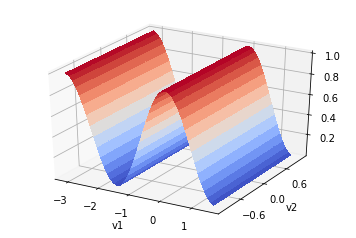

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline  
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import MaxNLocator

fig = plt.figure(figsize = (6, 4))
ax = fig.gca(projection='3d')

X = np.arange(-3.1, 1.6, 0.1)
Y = np.arange(-1., 1.25, 0.25)

xx, yy = np.meshgrid(X, Y)
Z = np.array([[objective([x, y]) for x in X] for y in Y]).reshape(len(Y), len(X))
surf = ax.plot_surface(xx, yy, Z, cmap=cm.coolwarm, antialiased=False)

ax.set_xlabel("v1")
ax.set_ylabel("v2")
ax.zaxis.set_major_locator(MaxNLocator(nbins = 5, prune = 'lower'))
ax.yaxis.set_major_locator(MaxNLocator(nbins = 4, prune = 'lower'))

plt.show()

As stated above, the gradient does not depend on the phase parameter $v_2$; hence, the landscape is flat along lines parallel to the $v_2$-axis.

### Optimization

We choose a simple GradientDescentOptimizer with a step size of 0.1.

In [6]:
opt = GradientDescentOptimizer(stepsize=0.1)

The initial values of the variabels are set to near-zero. This corresponds to an identity gate, in other words, the circuit leaves the photon in the first mode. 

*Note that at exactly zero the gradient vanishes, and the optimization algorithm will not descend from the starting point. We therefore add some small offsets to avoid this critical point.* 

In [7]:
var_init = np.array([0.01, 0.01])

We optimize the weights for 100 steps.

In [8]:
var = var_init
var_gd = []

for iteration in range(100):
    var = opt.step(objective, var)
    var_gd.append(var)
    
    if iteration % 10 == 0:
        print('Cost after step {:3d}: {:0.7f} | Variables [{:0.7f}, {:0.7f}]'
              ''.format(iteration, objective(var), var[0], var[1]))

Cost after step   0: 0.9998560 | Variables [0.0119999, 0.0100000]
Cost after step  10: 0.9945046 | Variables [0.0741993, 0.0100000]
Cost after step  20: 0.8206168 | Variables [0.4373458, 0.0100000]
Cost after step  30: 0.0723227 | Variables [1.2985156, 0.0100000]
Cost after step  40: 0.0009153 | Variables [1.5405375, 0.0100000]
Cost after step  50: 0.0000106 | Variables [1.5675459, 0.0100000]
Cost after step  60: 0.0000001 | Variables [1.5704473, 0.0100000]
Cost after step  70: 0.0000000 | Variables [1.5707589, 0.0100000]
Cost after step  80: 0.0000000 | Variables [1.5707923, 0.0100000]
Cost after step  90: 0.0000000 | Variables [1.5707959, 0.0100000]


Starting at a different offset, we train the MomentumOptimizer, which improves on gradient descent by making each update dependent on the previous gradient, like how a ball rolling down a hill accumulates momentum.

In [9]:
mm = MomentumOptimizer(stepsize=0.1, momentum=0.5)

var_init = np.array([0.01, 0.5])

var = var_init
var_mm = []

for iteration in range(100):
    var = mm.step(objective, var)
    var_mm.append(var)

    if iteration % 10 == 0:
        print('Cost after step {:3d}: {:0.7f} | Variables [{:0.7f}, {:0.7f}]'
              ''.format(iteration, objective(var), var[0], var[1]))

Cost after step   0: 0.9998560 | Variables [0.0119999, 0.5000000]
Cost after step  10: 0.9657205 | Variables [0.1862217, 0.5000000]
Cost after step  20: 0.0055535 | Variables [1.4962052, 0.5000000]
Cost after step  30: 0.0000064 | Variables [1.5682634, 0.5000000]
Cost after step  40: 0.0000000 | Variables [1.5709673, 0.5000000]
Cost after step  50: 0.0000000 | Variables [1.5707922, 0.5000000]
Cost after step  60: 0.0000000 | Variables [1.5707963, 0.5000000]
Cost after step  70: 0.0000000 | Variables [1.5707963, 0.5000000]
Cost after step  80: 0.0000000 | Variables [1.5707963, 0.5000000]
Cost after step  90: 0.0000000 | Variables [1.5707963, 0.5000000]


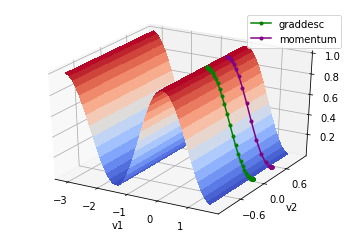

In [21]:
fig = plt.figure(figsize = (6, 4))
ax = fig.gca(projection='3d')

X = np.arange(-3.1, 1.6, 0.1)
Y = np.arange(-1., 1.25, 0.25)

xx, yy = np.meshgrid(X, Y)
Z = np.array([[objective([x, y]) for x in X] for y in Y]).reshape(len(Y), len(X))
surf = ax.plot_surface(xx, yy, Z, cmap=cm.coolwarm, antialiased=False)

path_z = [objective(var)+1e-8 for var in var_gd]
path_x = [var[0] for var in var_gd]
path_y = [var[1] for var in var_gd]
ax.plot(path_x, path_y, path_z, c='green', marker='.', label="graddesc")

path_z = [objective(var)+1e-8 for var in var_mm]
path_x = [var[0] for var in var_mm]
path_y = [var[1] for var in var_mm]
ax.plot(path_x, path_y, path_z, c='purple', marker='.', label="momentum")

ax.set_xlabel("v1")
ax.set_ylabel("v2")
ax.zaxis.set_major_locator(MaxNLocator(nbins = 5, prune = 'lower'))
ax.yaxis.set_major_locator(MaxNLocator(nbins = 4, prune = 'lower'))

plt.legend()
plt.show()